In [ ]:
pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: toolz
    Found existing installation: toolz 0.12.1
    Uninstalling toolz-0.12.1:
      Successfully uninstalled toolz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


In [ ]:
# Import Stuff: You may not need everything here
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import scipy.optimize as optimize
from numpy import random
from numpy import linalg
import yfinance as yf

import pandas_market_calendars as mcal

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Communication Sector: Google, Meta, Netflix, T-Mobile, Walt Disney Co.
# Consumer Disc. Sector:  Amazon, Tesla, Mcdonalds, Starbucks, Nike

comm_stocks = ['GOOGL', 'META', 'NFLX', 'TMUS', 'DIS']
cons_stocks = ['AMZN', 'TSLA', 'MCD', 'SBUX', 'NKE']

all_stocks = comm_stocks + cons_stocks + ["^GSPC"]

# Date range
start_date = "2017-12-29"   # last trading day of 2017
end_date = "2018-12-31"     # all of 2018

# # data = yf.download(all_stocks, start=start_date, end=end_date)["Close"]

# #Save data locally to not pull down again
# data.to_csv("/content/drive/MyDrive/fsp_ps2_stock_prices_2018.csv")
data = pd.read_csv("/content/drive/MyDrive/fsp_ps2_stock_prices_2018.csv", index_col=0, parse_dates=True)

In [ ]:
#Compute Daily Returns (Closing - Opening)/Opening

daily_returns = data.pct_change()
daily_returns.dropna(inplace=True) #Since no previous Opening to go off so just remove this row
daily_returns.to_csv("/content/drive/MyDrive/fsp_ps2_daily_returns_2018.csv")

In [ ]:
#Federal Treasury Bills from Code Snippet

fed_data= web.DataReader(['TB3SMFFM','FEDFUNDS'],'fred', start='2017-12-01', end='2018-12-31')
fed_data['3MO T-BILL']=fed_data['TB3SMFFM']+fed_data['FEDFUNDS']
fed_3mo_daily= (fed_data['3MO T-BILL'].resample(rule='B').ffill())/(100*252)

#To accurately get trading days in 2018 (NYSE and NASDAQ have same days)
nyse = mcal.get_calendar('XNYS')
trading_days = nyse.valid_days(start_date='2017-12-29', end_date='2018-12-31')
trading_days = pd.to_datetime(trading_days).tz_localize(None)

rf_daily_trading_days = fed_3mo_daily.reindex(trading_days).ffill().bfill()
rf_daily_trading_days = rf_daily_trading_days.reindex(daily_returns.index).ffill() #reindex to guarantee no slip ups

In [ ]:
#Excess Returns
excess_returns = daily_returns.sub(rf_daily_trading_days, axis=0)
excess_returns = excess_returns.dropna(how='any')

# Part 1

In [ ]:
# (a) Compute (mu, sigma)

stock_cols = ['GOOGL','META','NFLX','TMUS','DIS','AMZN','TSLA','MCD','SBUX','NKE']
sp500_col = '^GSPC'

mu_stocks = excess_returns[stock_cols].mean()
mu_sp500 = excess_returns[sp500_col].mean()

cov_stocks = excess_returns[stock_cols].cov()
var_sp500 = excess_returns[sp500_col].std()

#For each sector
mu_comms = excess_returns[comm_stocks].mean()
mu_cons = excess_returns[cons_stocks].mean()

cov_comms = excess_returns[comm_stocks].cov()
cov_cons = excess_returns[cons_stocks].cov()

In [ ]:
# Print out the Covariance matrices
print(cov_stocks)
print(cov_comms)
print(cov_cons)

          GOOGL      META      NFLX      TMUS       DIS      AMZN      TSLA  \
GOOGL  0.000317  0.000268  0.000337  0.000140  0.000135  0.000301  0.000227   
META   0.000268  0.000576  0.000345  0.000144  0.000111  0.000318  0.000248   
NFLX   0.000337  0.000345  0.000851  0.000223  0.000196  0.000485  0.000360   
TMUS   0.000140  0.000144  0.000223  0.000253  0.000089  0.000178  0.000170   
DIS    0.000135  0.000111  0.000196  0.000089  0.000174  0.000142  0.000147   
AMZN   0.000301  0.000318  0.000485  0.000178  0.000142  0.000519  0.000302   
TSLA   0.000227  0.000248  0.000360  0.000170  0.000147  0.000302  0.001366   
MCD    0.000060  0.000070  0.000085  0.000036  0.000057  0.000062  0.000098   
SBUX   0.000098  0.000085  0.000117  0.000064  0.000070  0.000129  0.000099   
NKE    0.000154  0.000124  0.000225  0.000098  0.000111  0.000195  0.000221   

            MCD      SBUX       NKE  
GOOGL  0.000060  0.000098  0.000154  
META   0.000070  0.000085  0.000124  
NFLX   0.000085 

In [ ]:
def mean_upper_triangle(df):
    total = 0
    count = 0
    for i in range(len(df)):
        for j in range(i + 1, len(df)):  # only upper triangle (i < j)
            total += df.iloc[i, j]
            count += 1
    return total / count

In [ ]:
# (b) Since the matrices are symmetric and PD

cov_stocks_evals = np.linalg.eigvals(cov_stocks)

cov_comms_evals = np.linalg.eigvals(cov_comms)
cov_cons_evals = np.linalg.eigvals(cov_cons)

min_stocks, max_stocks = cov_stocks_evals.min(), cov_stocks_evals.max()
min_comms, max_comms = cov_comms_evals.min(), cov_comms_evals.max()
min_cons, max_cons = cov_cons_evals.min(), cov_cons_evals.max()

#Evaluate condtion number --> smaller is better (less spread)
cond_stocks = max_stocks/min_stocks
cond_comms = max_comms/min_comms
cond_cons = max_cons/min_cons

#Correlation Matrix
corr_stocks = excess_returns.corr().drop(columns='^GSPC')

#Cross-Sector Correlation Matrix
corr_cross = corr_stocks.loc[comm_stocks, cons_stocks]
print("Correlation Values Across Sectors. \n")

for r in comm_stocks:
    for c in cons_stocks:
        rho_ij = corr_cross.loc[r, c]
        print(f"ρ({r}, {c}) = {rho_ij:.3f}")
print("")

#Correlation Matrix within each sector
corr_comms = excess_returns[comm_stocks].corr()
print("Correlation Matrix for Comms. \n")
print(corr_comms)
print("")

corr_cons = excess_returns[cons_stocks].corr()
print("Correlation Matrix for Consumer Disc. \n")
print(corr_cons)
print("")

#Average Correlation Comparison
avg_corr_cross = corr_stocks.loc[comm_stocks, cons_stocks].stack().mean()
avg_corr_comm = mean_upper_triangle(corr_comms)
avg_corr_cons = mean_upper_triangle(corr_cons)

print(f"Average Corr (Cross Sector) = {avg_corr_cross:.3f}")
print(f"Average Corr (Comm) = {avg_corr_comm:.3f}")
print(f"Average Corr (Cons) = {avg_corr_cons:.3f}")

print("")
print(f"All stocks p: {cond_stocks}")
print(f"Comm Sector p: {cond_comms}")
print(f"Consumer sector p: {cond_cons}")

Correlation Values Across Sectors. 

ρ(GOOGL, AMZN) = 0.742
ρ(GOOGL, TSLA) = 0.345
ρ(GOOGL, MCD) = 0.260
ρ(GOOGL, SBUX) = 0.371
ρ(GOOGL, NKE) = 0.468
ρ(META, AMZN) = 0.582
ρ(META, TSLA) = 0.279
ρ(META, MCD) = 0.225
ρ(META, SBUX) = 0.239
ρ(META, NKE) = 0.280
ρ(NFLX, AMZN) = 0.730
ρ(NFLX, TSLA) = 0.333
ρ(NFLX, MCD) = 0.223
ρ(NFLX, SBUX) = 0.272
ρ(NFLX, NKE) = 0.416
ρ(TMUS, AMZN) = 0.491
ρ(TMUS, TSLA) = 0.290
ρ(TMUS, MCD) = 0.175
ρ(TMUS, SBUX) = 0.273
ρ(TMUS, NKE) = 0.332
ρ(DIS, AMZN) = 0.472
ρ(DIS, TSLA) = 0.302
ρ(DIS, MCD) = 0.330
ρ(DIS, SBUX) = 0.359
ρ(DIS, NKE) = 0.455

Correlation Matrix for Comms. 

          GOOGL      META      NFLX      TMUS       DIS
GOOGL  1.000000  0.627385  0.649457  0.496163  0.572759
META   0.627385  1.000000  0.492935  0.377358  0.349057
NFLX   0.649457  0.492935  1.000000  0.481181  0.507966
TMUS   0.496163  0.377358  0.481181  1.000000  0.424745
DIS    0.572759  0.349057  0.507966  0.424745  1.000000

Correlation Matrix for Consumer Disc. 

          AMZ

The correlations within one stronger are not necessarily stronger than across both sectors. This is dependent on the sector: within the Communications and technology sector, the correlation is higher since all stocks emphasize technology and hence have relevant performances accoridng to trends. In the consumer disc. sector, we have stocks in Amazon vs. Starbucks which are not as closely related to each other. Of course since I chose companies listed on the S&P500, there will be some correlation amongst the 2 sectors due to macro events that transcend field-specific events.

There is no general trend between correlation and the condition number.

In [ ]:
# (c) Compute Single Factor model

cov_with_sp500 = excess_returns[stock_cols].apply(lambda x: x.cov(excess_returns[sp500_col]))
beta = cov_with_sp500/var_sp500

alpha = mu_stocks - beta*mu_sp500

residual = excess_returns[stock_cols].subtract(alpha, axis=1) - excess_returns[sp500_col].values[:, None] * beta.values

#Correlation matrix of residuals
residual_corr = residual.corr()
print(residual_corr)

corr_resid_comm = residual_corr.loc[comm_stocks, comm_stocks]
corr_resid_cons = residual_corr.loc[cons_stocks, cons_stocks]
corr_resid_cross = residual_corr.loc[comm_stocks, cons_stocks]
print("")
print("Comm Sector Residual Correlation Matrix")
print(corr_resid_comm)
print("")
print("Cons Sector Residual Correlation Matrix")
print(corr_resid_cons)
print("")
print("Cross Sector Residual Correlation Matrix")
print(corr_resid_cross)

avg_res_comm = corr_resid_comm.values[np.triu_indices(len(comm_stocks), 1)].mean()
avg_res_cons = corr_resid_cons.values[np.triu_indices(len(cons_stocks), 1)].mean()
avg_res_cross = corr_resid_cross.values.mean()

print("")
print(f"Average Correlation (Comm) = {avg_res_comm:.3f}")
print(f"Average Correlation (Cons) = {avg_res_cons:.3f}")
print(f"Average Correlation (Cross) = {avg_res_cross:.3f}")

          GOOGL      META      NFLX      TMUS       DIS      AMZN      TSLA  \
GOOGL  1.000000  0.624000  0.645335  0.491319  0.567457  0.738021  0.340965   
META   0.624000  1.000000  0.488718  0.372924  0.343434  0.578146  0.275779   
NFLX   0.645335  0.488718  1.000000  0.476848  0.502858  0.727346  0.329798   
TMUS   0.491319  0.372924  0.476848  1.000000  0.419779  0.486675  0.286149   
DIS    0.567457  0.343434  0.502858  0.419779  1.000000  0.466039  0.298057   
AMZN   0.738021  0.578146  0.727346  0.486675  0.466039  1.000000  0.354628   
TSLA   0.340965  0.275779  0.329798  0.286149  0.298057  0.354628  1.000000   
MCD    0.254622  0.220424  0.218228  0.170868  0.326307  0.204355  0.199985   
SBUX   0.366349  0.234632  0.266882  0.268480  0.354798  0.378473  0.178181   
NKE    0.462643  0.274383  0.411129  0.326869  0.449946  0.457825  0.319329   

            MCD      SBUX       NKE  
GOOGL  0.254622  0.366349  0.462643  
META   0.220424  0.234632  0.274383  
NFLX   0.218228 

I would say the diagonal model does not make sense since the residual correlations off the diagonal is not 0. Ideally they should be 0 or close since error should not really have any correlation, yet we see the average values between 0.3-0.4.

Similarly, there is no general trend for residual correlation within 2 sectors compared to all stocks aggregated together.

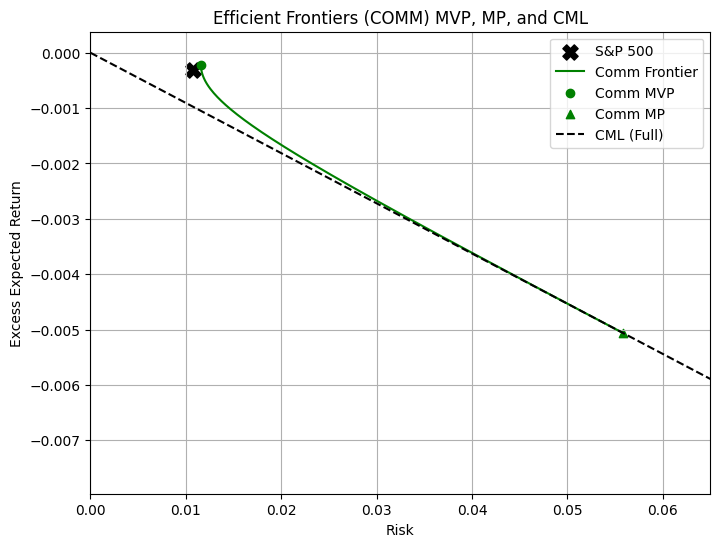

In [ ]:
def compute_mpt_frontier(mean_vec, cov_mat, stock_list):
    n = len(stock_list)
    ones = np.ones(n)
    Cinv = np.linalg.inv(cov_mat)

    # computing weights, mean, sigma for MVP
    w_mvp = Cinv @ ones / (ones @ Cinv @ ones)
    mu_mvp = w_mvp @ mean_vec
    sig_mvp = np.sqrt(w_mvp @ cov_mat @ w_mvp)

    # computing weights, mean, sigma for MP
    w_mp = Cinv @ mean_vec q/ (ones @ Cinv @ mean_vec)
    mu_mp = w_mp @ mean_vec
    sig_mp = np.sqrt(w_mp @ cov_mat @ w_mp)
    sharpe = mu_mp / sig_mp

    a = ones @ Cinv @ ones
    b = ones @ Cinv @ mean_vec
    c = mean_vec @ Cinv @ mean_vec
    d = a * c - b * b

    grid = np.linspace(mu_mvp, mu_mp, 200) # to generate actual mathematical "efficient frontier"

    mu_max = max(mean_vec.max(), mu_mvp)
    # grid = np.linspace(mu_mvp, mu_max, 200) # to force "upper curve" of the markowitz bullet otherwise this isnt the actual efficient frontier right?

    risks = []
    for mu_t in grid:
        lam1 = (c - b * mu_t) / d
        lam2 = (a * mu_t - b) / d
        w = lam1 * (Cinv @ ones) + lam2 * (Cinv @ mean_vec)
        risks.append(np.sqrt(w @ cov_mat @ w))

    cml_sig = np.linspace(0, 1.5 * sig_mp, 200)   # choose risk (x-axis)
    cml_mu  = sharpe * cml_sig

    return {
        "w_mvp": pd.Series(w_mvp, index=stock_list),
        "w_mp": pd.Series(w_mp, index=stock_list),
        "mu_mvp": mu_mvp,
        "sig_mvp": sig_mvp,
        "mu_mp": mu_mp,
        "sig_mp": sig_mp,
        "sharpe": sharpe,
        "frontier_mu": grid,
        "frontier_sig": np.array(risks),
        "cml_mu": cml_mu,
        "cml_sig": cml_sig
    }

comm_res = compute_mpt_frontier(mu_comms, cov_comms, comm_stocks)

rf = rf_daily_trading_days.mean()

plt.figure(figsize=(8, 6))

plt.scatter(var_sp500, mu_sp500, color='black', marker='X', s=120, label='S&P 500')

plt.plot(comm_res["frontier_sig"], comm_res["frontier_mu"], 'g', label='Comm Frontier')
plt.scatter(comm_res["sig_mvp"], comm_res["mu_mvp"], color='green', label='Comm MVP')
plt.scatter(comm_res["sig_mp"],  comm_res["mu_mp"],  color='green', marker='^', label='Comm MP')

plt.plot(comm_res["cml_sig"], comm_res["cml_mu"], 'k--', label='CML (Full)')

plt.xlim(0, 0.065)

plt.xlabel("Risk")
plt.ylabel("Excess Expected Return")
plt.title("Efficient Frontiers (COMM) MVP, MP, and CML")
plt.grid(True)
plt.legend()
plt.show()

# Comment: Since MP is below RF, MPT breaks

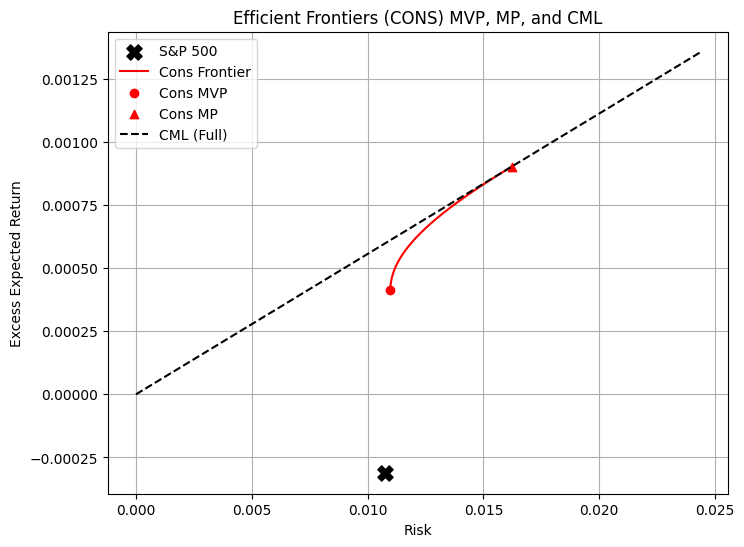

In [ ]:
cons_res = compute_mpt_frontier(mu_cons, cov_cons, cons_stocks)
plt.figure(figsize=(8, 6))

plt.scatter(var_sp500, mu_sp500, color='black', marker='X', s=120, label='S&P 500')

plt.plot(cons_res["frontier_sig"], cons_res["frontier_mu"], 'r', label='Cons Frontier')
plt.scatter(cons_res["sig_mvp"], cons_res["mu_mvp"], color='red', label='Cons MVP')
plt.scatter(cons_res["sig_mp"],  cons_res["mu_mp"],  color='red', marker='^', label='Cons MP')

plt.plot(cons_res["cml_sig"], cons_res["cml_mu"], 'k--', label='CML (Full)')

plt.xlabel("Risk")
plt.ylabel("Excess Expected Return")
plt.title("Efficient Frontiers (CONS) MVP, MP, and CML")
plt.grid(True)
plt.legend()
plt.show()

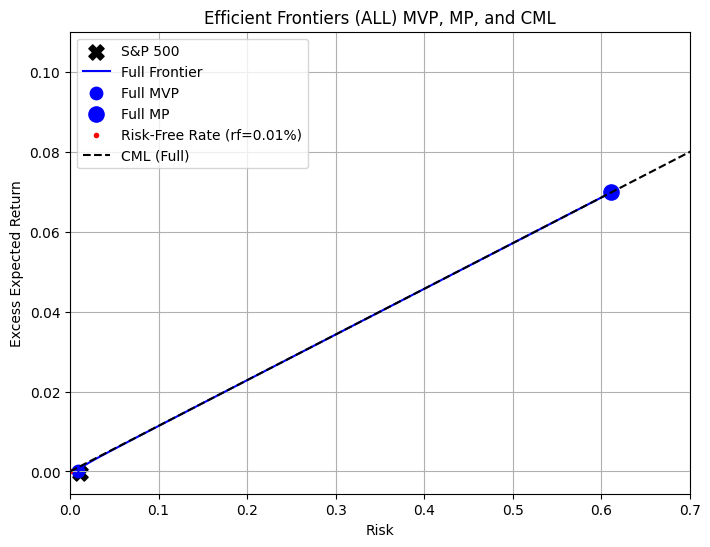

In [ ]:
full_res = compute_mpt_frontier(mu_stocks, cov_stocks, stock_cols)
plt.figure(figsize=(8, 6))

plt.scatter(var_sp500, mu_sp500, color='black', marker='X', s=120, label='S&P 500')

plt.plot(full_res["frontier_sig"], full_res["frontier_mu"], 'b', label='Full Frontier')
plt.scatter(full_res["sig_mvp"], full_res["mu_mvp"], color='blue', s=80, label='Full MVP')
plt.scatter(full_res["sig_mp"],  full_res["mu_mp"],  color='blue', s=120, marker='o', label='Full MP')
plt.scatter(0, rf, color='red', marker='.', label=f'Risk-Free Rate (rf={rf:.2%})')

plt.plot(full_res["cml_sig"], full_res["cml_mu"], 'k--', label='CML (Full)')

plt.xlim(0, 0.7)

plt.xlabel("Risk")
plt.ylabel("Excess Expected Return")
plt.title("Efficient Frontiers (ALL) MVP, MP, and CML")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# part (e)
'''
It seems like there is major short selling the Comms Sector because the MP
lies on the lower branch of the Markowitz Bullet
with a negative excess return and much higher risk which typically occurs only
when using large positive and negative weights to combine poorly performing assets.

Otherwise both Cons Sector and All stocks together do not indicate short selling
since both reflect somewhat standard looking efficient frontiers.
'''

'\nIt seems like there is major short selling the Comms Sector because the MP\nlies on the lower branch of the Markowitz Bullet\nwith a negative excess return and much higher risk which typically occurs only\nwhen using large positive and negative weights to combine poorly performing assets.\n\nOtherwise both Cons Sector and All stocks together do not indicate short selling\nsince both reflect somewhat standard looking efficient frontiers.\n'

In [ ]:
# part (f)
def compute_mp_returns(excess_returns, mp_weights, stock_list):
    return excess_returns[stock_list].dot(mp_weights)

def compute_betas_mp(excess_returns, mp_returns, stock_list):
    betas = {}
    var_mp = np.var(mp_returns)

    for stock in stock_list:
        cov = np.cov(excess_returns[stock], mp_returns)[0, 1]
        betas[stock] = cov / var_mp if var_mp != 0 else np.nan

    return pd.Series(betas)

mp_full_returns = compute_mp_returns(excess_returns, full_res["w_mp"], stock_cols)
mp_comm_returns = compute_mp_returns(excess_returns, comm_res["w_mp"], comm_stocks)
mp_cons_returns = compute_mp_returns(excess_returns, cons_res["w_mp"], cons_stocks)

betas_full_mp = compute_betas_mp(excess_returns, mp_full_returns, stock_cols)
betas_comm_mp = compute_betas_mp(excess_returns, mp_comm_returns, comm_stocks)
betas_cons_mp = compute_betas_mp(excess_returns, mp_cons_returns, cons_stocks)

def beta_df(title, beta_series):
    print("\n" + title)
    print(beta_series.to_frame(name="Beta"))
    print()

beta_df("Betas Relative to Full 10-Stock MP:", betas_full_mp)
beta_df("Betas Relative to Communications MP:", betas_comm_mp)
beta_df("Betas Relative to Consumer Discretionary MP:", betas_cons_mp)



Betas Relative to Full 10-Stock MP:
           Beta
GOOGL  0.000806
META  -0.012972
NFLX   0.021545
TMUS   0.000453
DIS    0.000937
AMZN   0.016065
TSLA   0.012516
MCD    0.002687
SBUX   0.007440
NKE    0.011113


Betas Relative to Communications MP:
           Beta
GOOGL -0.011146
META   0.179424
NFLX  -0.297998
TMUS  -0.006261
DIS   -0.012955


Betas Relative to Consumer Discretionary MP:
          Beta
AMZN  1.245258
TSLA  0.970140
MCD   0.208276
SBUX  0.576729
NKE   0.861452



# Part 2


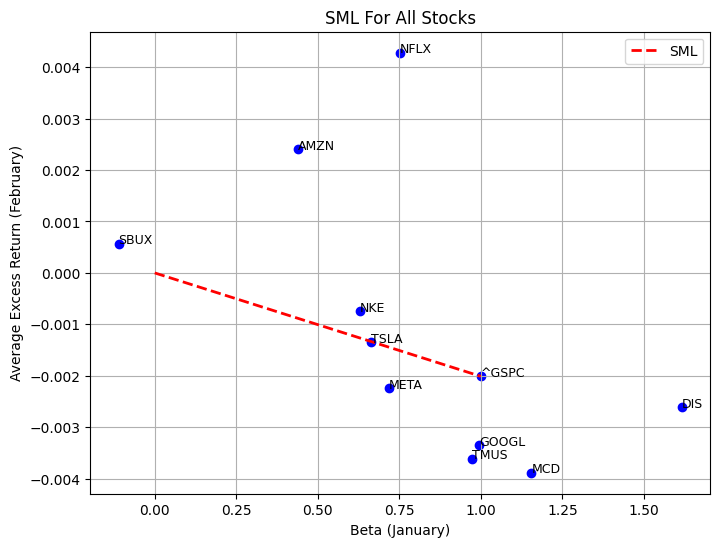

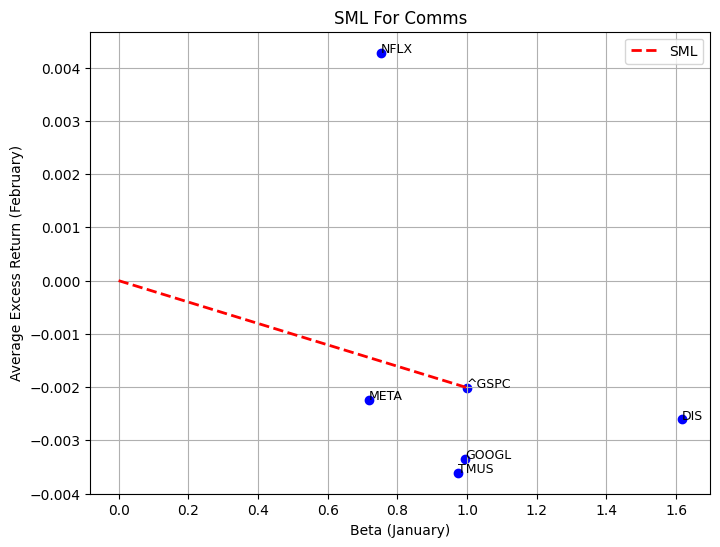

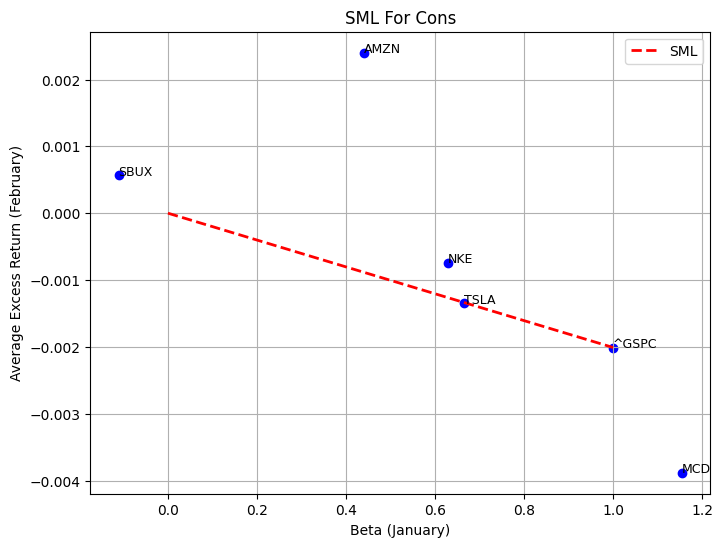

In [ ]:
jan = excess_returns.loc["2018-01-01":"2018-01-31"].dropna()
feb = excess_returns.loc["2018-02-01":"2018-02-28"].dropna()
sp = "^GSPC"

def compute_betas(df, stock_list, sp_col="^GSPC"):
    betas = {}
    sp_var = df[sp_col].var()

    for s in stock_list:
        cov = df[s].cov(df[sp_col])
        betas[s] = cov / sp_var

    betas[sp_col] = 1.0 # S&P500 beta = 1
    return betas

def average_feb_returns(df, stock_list, sp_col="^GSPC"):
    avg = {}
    for s in stock_list:
        avg[s] = df[s].mean()
    avg[sp_col] = df[sp_col].mean()
    return avg

def plot_sml(betas, avg_returns, title):
    stocks = list(betas.keys())

    x = np.array([betas[s] for s in stocks]) # Betas
    y = np.array([avg_returns[s] for s in stocks]) # Feb returns

    # SML line from (0, 0) to (1, r_SP500_Feb)
    sp_ret = avg_returns["^GSPC"]
    sml_x = np.array([0, 1])
    sml_y = np.array([0, sp_ret])

    plt.figure(figsize=(8,6))
    plt.scatter(x, y, color='blue')

    # Label points
    for s in stocks:
        plt.text(betas[s], avg_returns[s], s, fontsize=9)

    plt.plot(sml_x, sml_y, 'r--', linewidth=2, label="SML")
    plt.xlabel("Beta (January)")
    plt.ylabel("Average Excess Return (February)")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

full_list = stock_cols
betas_full = compute_betas(jan, full_list, sp)
avg_full   = average_feb_returns(feb, full_list, sp)

plot_sml(betas_full, avg_full, title="SML For All Stocks")

betas_comm = compute_betas(jan, comm_stocks, sp)
avg_comm   = average_feb_returns(feb, comm_stocks, sp)

plot_sml(betas_comm, avg_comm, title="SML For Comms")

betas_cons = compute_betas(jan, cons_stocks, sp)
avg_cons   = average_feb_returns(feb, cons_stocks, sp)

plot_sml(betas_cons, avg_cons, title="SML For Cons")



# Part 3

Final wealth:
 All Stocks MP: 0.3187
 Comms MP: 0.5485
 Cons MP: 1.2093
 S&P 500: 0.8803

Any portfolio's go negative?
 All Stocks False
 Comms  False
 Cons  False

2018 kinda sucked no?



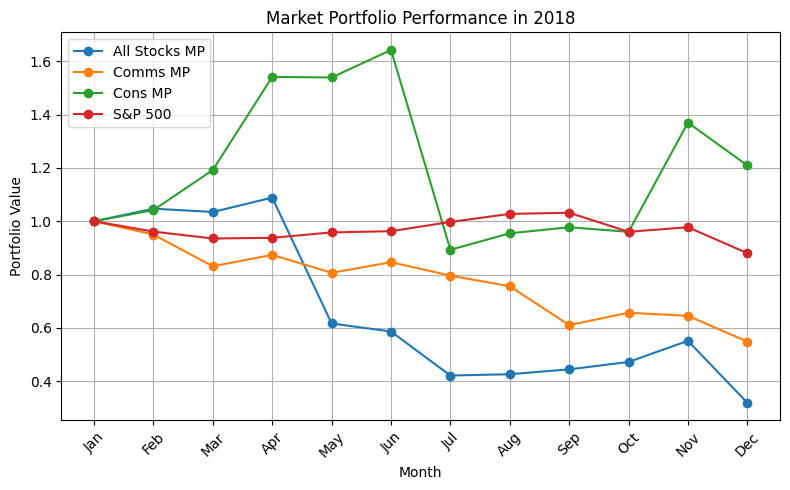

In [ ]:
sp500_col = '^GSPC'

def month_slice(df, year, month):
    return df[(df.index.year == year) & (df.index.month == month)]

def compute_mp_for_month(excess_df_month, tickers):
    R = excess_df_month[tickers]
    mu = R.mean().values
    cov = R.cov().values

    inv_cov = np.linalg.inv(cov)
    w_raw = inv_cov @ mu
    w = w_raw / np.sum(w_raw)
    return w

def monthly_portfolio_return(daily_df_month, tickers, weights):
    R = daily_df_month[tickers].values
    daily_port_ret = R @ weights
    month_return = np.prod(1 + daily_port_ret) - 1
    return month_return

year = 2018
months = list(range(1, 13))


# Initial wealth (at end of January)
wealth_full = [1.0]
wealth_comm = [1.0]
wealth_cons = [1.0]
wealth_sp   = [1.0]

month_labels = ['Jan']  # for plotting

for idx in range(1, len(months)): # start at Feb (index 1)
    prev_m = months[idx - 1] # month used to compute MP
    curr_m = months[idx] # month whose returns we earn

    excess_prev = month_slice(excess_returns, year, prev_m)
    daily_curr  = month_slice(daily_returns,  year, curr_m)

    w_full = compute_mp_for_month(excess_prev, stock_cols)
    w_comm = compute_mp_for_month(excess_prev, comm_stocks)
    w_cons = compute_mp_for_month(excess_prev, cons_stocks)

    ret_full = monthly_portfolio_return(daily_curr, stock_cols,   w_full)
    ret_comm = monthly_portfolio_return(daily_curr, comm_stocks,  w_comm)
    ret_cons = monthly_portfolio_return(daily_curr, cons_stocks,  w_cons)

    sp_month = daily_curr[sp500_col].values
    ret_sp = np.prod(1 + sp_month) - 1

    wealth_full.append(wealth_full[-1] * (1 + ret_full))
    wealth_comm.append(wealth_comm[-1] * (1 + ret_comm))
    wealth_cons.append(wealth_cons[-1] * (1 + ret_cons))
    wealth_sp.append(wealth_sp[-1] * (1 + ret_sp))

    month_labels.append(pd.to_datetime(f"{year}-{curr_m:02d}-01").strftime('%b'))

wealth_full = np.array(wealth_full)
wealth_comm = np.array(wealth_comm)
wealth_cons = np.array(wealth_cons)
wealth_sp   = np.array(wealth_sp)

print("Final wealth:")
print(f" All Stocks MP: {wealth_full[-1]:.4f}")
print(f" Comms MP: {wealth_comm[-1]:.4f}")
print(f" Cons MP: {wealth_cons[-1]:.4f}")
print(f" S&P 500: {wealth_sp[-1]:.4f}")
print("")

print("Any portfolio's go negative?")
print(" All Stocks", np.any(wealth_full < 0))
print(" Comms ", np.any(wealth_comm < 0))
print(" Cons ", np.any(wealth_cons < 0))
print("")

print("2018 kinda sucked no?")
print("")

plt.figure(figsize=(8,5))
plt.plot(month_labels, wealth_full, marker='o', label='All Stocks MP')
plt.plot(month_labels, wealth_comm, marker='o', label='Comms MP')
plt.plot(month_labels, wealth_cons, marker='o', label='Cons MP')
plt.plot(month_labels, wealth_sp,   marker='o', label='S&P 500')

plt.xlabel("Month")
plt.ylabel("Portfolio Value")
plt.title("Market Portfolio Performance in 2018")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
